In [1]:
import os
import mne
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,ConfusionMatrixDisplay,roc_curve, auc
import matplotlib.pyplot as plt
from graphviz import Digraph

print("All imports successful!")

All imports successful!


In [2]:
data_dir = '/Users/andrewding/Desktop/AI-in-ERP-for-stroke/model_test/selected_dom_paper'

In [3]:
mapping = {
    'C1': 'C2',
    'C2': 'C1',
    'C3': 'C4',
    'C4': 'C3',
    'C5': 'C6',
    'C6': 'C5',
    'CP1': 'CP2',
    'CP2': 'CP1',
    'CP3': 'CP4',
    'CP4': 'CP3',
    'CP5': 'CP6',
    'CP6': 'CP5'
}

In [4]:
# ####### Left side has normal activities and right side has lesion

# # Define the folder containing the data and the channels to pick
# data_fd = data_dir
# channels = ['C5', 'C3', 'C1', 'CP1', 'CP3', 'CP5', 'C2', 'C4', 'C6', 'CP2', 'CP4', 'CP6']

# #                   [1.   ,  2. ,  3. ,   4. ,  5  ,   6  ,  7  ,   8  ,  9. ,  10. ,  11 ,  12]
# new_ch_order = ['C1', 'CP1', 'C3', 'CP3', 'C5', 'CP5', 'C2', 'CP2', 'C4', 'CP4', 'C6', 'CP6']
# epochs_data = []

# # Initialize dictionaries to track epoch counts per file and by class
# fl_epo_con = {}
# cls_epo_con = {'S': 0, 'C': 0}  # 'S' for Stroke, 'C' for Control

# flag = 0
# # Iterate over each folder in the data directory
# for subfolder in os.listdir(data_fd):
#     subfolder_path = os.path.join(data_fd, subfolder)
#     if os.path.isdir(subfolder_path):
#         if subfolder.endswith('S'):
#             label = 0
#             class_key = 'S'
#         elif subfolder.endswith('C'):
#             label = 1
#             class_key = 'C'
#         else:
#             continue

#         for file in os.listdir(subfolder_path):
#             if file.endswith('.set'):
#                 file_path = os.path.join(subfolder_path, file)

#                 # Read the epochs data from the .set file
#                 epochs = mne.io.read_epochs_eeglab(file_path)

#                 # Pick only the specified channels
#                 epochs = epochs.pick(picks=channels)

#                 # Check if the file name contains '_R_' to flip the channels
#                 if 'R' in file:
#                     if flag == 0:
#                       epochs.plot(picks=channels)

#                     # Rename the channels after flipping
#                     epochs.rename_channels(mapping, allow_duplicates=False)

#                     if flag == 0:
#                       epochs.plot(picks=channels)
#                       flag = 1
#                     epochs.reorder_channels(new_ch_order)
#                     for epoch in epochs.get_data():
#                         epochs_data.append({'epoch': epoch, 'label': label})
#                 else:
#                     # Normal case without flipping
#                     epochs.reorder_channels(new_ch_order)
#                     for epoch in epochs.get_data():
#                         epochs_data.append({'epoch': epoch, 'label': label})

#                 # Count the number of epochs and update the dictionaries
#                 num_epochs = len(epochs)
#                 fl_epo_con[file] = num_epochs
#                 cls_epo_con[class_key] += num_epochs

# # Convert the list to a pandas DataFrame
# epochs_df = pd.DataFrame(epochs_data)




# Define the folder containing the data and the EEG channels to pick
data_fd = data_dir
channels = ['C5', 'C3', 'C1', 'CP1', 'CP3', 'CP5', 'C2', 'C4', 'C6', 'CP2', 'CP4', 'CP6']

# Define the new order of channels after reordering
new_ch_order = ['C1', 'CP1', 'C3', 'CP3', 'C5', 'CP5', 'C2', 'CP2', 'C4', 'CP4', 'C6', 'CP6']

# Define a mapping for flipping channel names (for right-side recordings)
channel_mapping = {
    'C1': 'C2', 'C2': 'C1', 'C3': 'C4', 'C4': 'C3',
    'C5': 'C6', 'C6': 'C5', 'CP1': 'CP2', 'CP2': 'CP1',
    'CP3': 'CP4', 'CP4': 'CP3', 'CP5': 'CP6', 'CP6': 'CP5'
}

# Initialize list to store extracted epochs and labels
epochs_data = []

# Initialize dictionaries to track epoch counts per file and by class
fl_epo_con = {}
cls_epo_con = {'S': 0, 'C': 0}  # 'S' for Stroke, 'C' for Control

# Iterate over each folder in the data directory
for subfolder in os.listdir(data_fd):
    subfolder_path = os.path.join(data_fd, subfolder)
    if os.path.isdir(subfolder_path):
        # Assign label: 0 for Stroke ('S'), 1 for Control ('C')
        if subfolder.endswith('S'):
            label = 0
            class_key = 'S'
        elif subfolder.endswith('C'):
            label = 1
            class_key = 'C'
        else:
            continue  # Skip folders that do not match expected class names

        for file in os.listdir(subfolder_path):
            if file.endswith('.set'):
                file_path = os.path.join(subfolder_path, file)

                # Read the epochs data from the .set file
                epochs = mne.io.read_epochs_eeglab(file_path)

                # Pick only the specified channels (to ensure the correct number of channels)
                epochs = epochs.pick(picks=channels)

                # If the file name contains '_R_', flip the channels using the mapping
                if '_R_' in file:
                    epochs.rename_channels(channel_mapping, allow_duplicates=False)

                # Reorder channels to match the expected order
                epochs.reorder_channels(new_ch_order)

                # Extract epoch data and append to list
                for epoch in epochs.get_data():
                    epochs_data.append({'epoch': epoch, 'label': label})

                # Count the number of epochs and update tracking dictionaries
                num_epochs = len(epochs)
                fl_epo_con[file] = num_epochs
                cls_epo_con[class_key] += num_epochs

# Convert the list to a pandas DataFrame
epochs_df = pd.DataFrame(epochs_data)

# Print dataset info for debugging
print(f"Extracted {len(epochs_df)} epochs from EEG dataset.")
print(f"DataFrame shape: {epochs_df.shape}")


Extracting parameters from /Users/andrewding/Desktop/AI-in-ERP-for-stroke/model_test/selected_dom_paper/025C/025C_sti_R_rest_cl.set...
Not setting metadata
217 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /Users/andrewding/Desktop/AI-in-ERP-for-stroke/model_test/selected_dom_paper/009C/009c_R_rest_cl-bsli.set...


/var/folders/8z/40472bf11xv5b_wxqh4l0z8m0000gn/T/ipykernel_69660/642394660.py:110: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path)
/var/folders/8z/40472bf11xv5b_wxqh4l0z8m0000gn/T/ipykernel_69660/642394660.py:110: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path)


Not setting metadata
404 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /Users/andrewding/Desktop/AI-in-ERP-for-stroke/model_test/selected_dom_paper/001S/001S-R-rest-cl.set...
Not setting metadata
367 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /Users/andrewding/Desktop/AI-in-ERP-for-stroke/model_test/selected_dom_paper/007C/007C_sti_R_rest_cl_bsli.set...
Not setting metadata
298 matching events found
No baseline correction applied
0 projection items activated
Ready.


/var/folders/8z/40472bf11xv5b_wxqh4l0z8m0000gn/T/ipykernel_69660/642394660.py:110: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path)
/var/folders/8z/40472bf11xv5b_wxqh4l0z8m0000gn/T/ipykernel_69660/642394660.py:110: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path)
/var/folders/8z/40472bf11xv5b_wxqh4l0z8m0000gn/T/ipykernel_69660/642394660.py:110: RuntimeWarning: Data file name in EEG.data (007C_R_rest.fdt) is incorrect, the file name must have changed on disk, using the correct file name (007C_sti_R_rest_cl_bsli.fdt).
  epochs = mne.io.read_epochs_eeglab(file_path)


Extracting parameters from /Users/andrewding/Desktop/AI-in-ERP-for-stroke/model_test/selected_dom_paper/002S/002s_sti_L_rest_cl_bsli.set...
Not setting metadata
385 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /Users/andrewding/Desktop/AI-in-ERP-for-stroke/model_test/selected_dom_paper/004C/004C_sti_R_rest_cl_bsli.set...
Not setting metadata
306 matching events found
No baseline correction applied
0 projection items activated
Ready.


/var/folders/8z/40472bf11xv5b_wxqh4l0z8m0000gn/T/ipykernel_69660/642394660.py:110: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path)
/var/folders/8z/40472bf11xv5b_wxqh4l0z8m0000gn/T/ipykernel_69660/642394660.py:110: RuntimeWarning: Data file name in EEG.data (sti_L_rest_cl_bsli.fdt) is incorrect, the file name must have changed on disk, using the correct file name (002s_sti_L_rest_cl_bsli.fdt).
  epochs = mne.io.read_epochs_eeglab(file_path)
/var/folders/8z/40472bf11xv5b_wxqh4l0z8m0000gn/T/ipykernel_69660/642394660.py:110: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path)
/var/folders/8z/40472bf11xv5b_wxqh4l0z8m0000gn/T/ipykernel_69660/642394660.py:110: RuntimeWarning: Data file name in EEG.data (004C_sti_R_rest_cl_rmbs.fdt) is incorrect, the file name must have changed on 

Extracting parameters from /Users/andrewding/Desktop/AI-in-ERP-for-stroke/model_test/selected_dom_paper/013S/013S-R-rest-cl-bsli.set...
Not setting metadata
219 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /Users/andrewding/Desktop/AI-in-ERP-for-stroke/model_test/selected_dom_paper/030C/030C_sti_R_rest_cl.set...
Not setting metadata
253 matching events found
No baseline correction applied
0 projection items activated
Ready.


/var/folders/8z/40472bf11xv5b_wxqh4l0z8m0000gn/T/ipykernel_69660/642394660.py:110: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path)
/var/folders/8z/40472bf11xv5b_wxqh4l0z8m0000gn/T/ipykernel_69660/642394660.py:110: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path)
/var/folders/8z/40472bf11xv5b_wxqh4l0z8m0000gn/T/ipykernel_69660/642394660.py:110: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path)


Extracting parameters from /Users/andrewding/Desktop/AI-in-ERP-for-stroke/model_test/selected_dom_paper/019S/019s_sti_L_rest_cl_bsli.set...
Not setting metadata
242 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /Users/andrewding/Desktop/AI-in-ERP-for-stroke/model_test/selected_dom_paper/011S/011s_sti_L_rest_cl_bsli.set...
Not setting metadata
215 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /Users/andrewding/Desktop/AI-in-ERP-for-stroke/model_test/selected_dom_paper/032C/032C_sti_R_rest_cl.set...
Not setting metadata
466 matching events found
No baseline correction applied
0 projection items activated
Ready.


/var/folders/8z/40472bf11xv5b_wxqh4l0z8m0000gn/T/ipykernel_69660/642394660.py:110: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path)
/var/folders/8z/40472bf11xv5b_wxqh4l0z8m0000gn/T/ipykernel_69660/642394660.py:110: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path)


Extracting parameters from /Users/andrewding/Desktop/AI-in-ERP-for-stroke/model_test/selected_dom_paper/034S/034S_sti_L_rest_cl.set...
Not setting metadata
368 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /Users/andrewding/Desktop/AI-in-ERP-for-stroke/model_test/selected_dom_paper/012S/012s_sti_L_rest_cl_bsli.set...
Not setting metadata
392 matching events found


/var/folders/8z/40472bf11xv5b_wxqh4l0z8m0000gn/T/ipykernel_69660/642394660.py:110: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path)
/var/folders/8z/40472bf11xv5b_wxqh4l0z8m0000gn/T/ipykernel_69660/642394660.py:110: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path)
/var/folders/8z/40472bf11xv5b_wxqh4l0z8m0000gn/T/ipykernel_69660/642394660.py:110: RuntimeWarning: Data file name in EEG.data (sti_L_rest_cl_bsli.fdt) is incorrect, the file name must have changed on disk, using the correct file name (012s_sti_L_rest_cl_bsli.fdt).
  epochs = mne.io.read_epochs_eeglab(file_path)


No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /Users/andrewding/Desktop/AI-in-ERP-for-stroke/model_test/selected_dom_paper/018S/018s_sti_R_rest_cl_bsli.set...
Not setting metadata
185 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /Users/andrewding/Desktop/AI-in-ERP-for-stroke/model_test/selected_dom_paper/031C/031C_sti_R_rest_cl.set...
Not setting metadata
529 matching events found


/var/folders/8z/40472bf11xv5b_wxqh4l0z8m0000gn/T/ipykernel_69660/642394660.py:110: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path)
/var/folders/8z/40472bf11xv5b_wxqh4l0z8m0000gn/T/ipykernel_69660/642394660.py:110: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path)


No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /Users/andrewding/Desktop/AI-in-ERP-for-stroke/model_test/selected_dom_paper/005C/005c_sti_R_rest_cl_bsli.set...
Not setting metadata
370 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /Users/andrewding/Desktop/AI-in-ERP-for-stroke/model_test/selected_dom_paper/029C/029C_sti_L_rest_cl.set...
Not setting metadata
226 matching events found
No baseline correction applied
0 projection items activated
Ready.


/var/folders/8z/40472bf11xv5b_wxqh4l0z8m0000gn/T/ipykernel_69660/642394660.py:110: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path)
/var/folders/8z/40472bf11xv5b_wxqh4l0z8m0000gn/T/ipykernel_69660/642394660.py:110: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path)


Extracting parameters from /Users/andrewding/Desktop/AI-in-ERP-for-stroke/model_test/selected_dom_paper/006C/006c-R-rest-cl-bsli_notgood.set...
Not setting metadata
217 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /Users/andrewding/Desktop/AI-in-ERP-for-stroke/model_test/selected_dom_paper/023C/023C_sti_R_rest_cl.set...
Not setting metadata
423 matching events found
No baseline correction applied
0 projection items activated
Ready.


/var/folders/8z/40472bf11xv5b_wxqh4l0z8m0000gn/T/ipykernel_69660/642394660.py:110: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path)
/var/folders/8z/40472bf11xv5b_wxqh4l0z8m0000gn/T/ipykernel_69660/642394660.py:110: RuntimeWarning: Data file name in EEG.data (006c-R-rest-cl-bsli.fdt) is incorrect, the file name must have changed on disk, using the correct file name (006c-R-rest-cl-bsli_notgood.fdt).
  epochs = mne.io.read_epochs_eeglab(file_path)
/var/folders/8z/40472bf11xv5b_wxqh4l0z8m0000gn/T/ipykernel_69660/642394660.py:110: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path)


Extracting parameters from /Users/andrewding/Desktop/AI-in-ERP-for-stroke/model_test/selected_dom_paper/027C/027C_sti_R_rest_cl.set...
Not setting metadata
418 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /Users/andrewding/Desktop/AI-in-ERP-for-stroke/model_test/selected_dom_paper/021S/021s_sti_L_rest_cl_bsli.set...
Not setting metadata
292 matching events found


/var/folders/8z/40472bf11xv5b_wxqh4l0z8m0000gn/T/ipykernel_69660/642394660.py:110: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path)
/var/folders/8z/40472bf11xv5b_wxqh4l0z8m0000gn/T/ipykernel_69660/642394660.py:110: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path)
/var/folders/8z/40472bf11xv5b_wxqh4l0z8m0000gn/T/ipykernel_69660/642394660.py:110: RuntimeWarning: Data file name in EEG.data (sti_L_rest_cl_bsli.fdt) is incorrect, the file name must have changed on disk, using the correct file name (021s_sti_L_rest_cl_bsli.fdt).
  epochs = mne.io.read_epochs_eeglab(file_path)


No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /Users/andrewding/Desktop/AI-in-ERP-for-stroke/model_test/selected_dom_paper/008C/008c_sti_L_rest_cl_bsli.set...
Not setting metadata
314 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /Users/andrewding/Desktop/AI-in-ERP-for-stroke/model_test/selected_dom_paper/024C/024C_sti_R_rest_cl.set...
Not setting metadata
395 matching events found
No baseline correction applied
0 projection items activated
Ready.


/var/folders/8z/40472bf11xv5b_wxqh4l0z8m0000gn/T/ipykernel_69660/642394660.py:110: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path)
/var/folders/8z/40472bf11xv5b_wxqh4l0z8m0000gn/T/ipykernel_69660/642394660.py:110: RuntimeWarning: Data file name in EEG.data (008c_sti_L_cl_bsli.fdt) is incorrect, the file name must have changed on disk, using the correct file name (008c_sti_L_rest_cl_bsli.fdt).
  epochs = mne.io.read_epochs_eeglab(file_path)
/var/folders/8z/40472bf11xv5b_wxqh4l0z8m0000gn/T/ipykernel_69660/642394660.py:110: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path)


Extracting parameters from /Users/andrewding/Desktop/AI-in-ERP-for-stroke/model_test/selected_dom_paper/016S/016s_sti_R_rest_cl_bsli.set...
Not setting metadata
330 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /Users/andrewding/Desktop/AI-in-ERP-for-stroke/model_test/selected_dom_paper/033S/033S_sti_L_rest_cl.set...
Not setting metadata
208 matching events found
No baseline correction applied
0 projection items activated
Ready.


/var/folders/8z/40472bf11xv5b_wxqh4l0z8m0000gn/T/ipykernel_69660/642394660.py:110: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path)
/var/folders/8z/40472bf11xv5b_wxqh4l0z8m0000gn/T/ipykernel_69660/642394660.py:110: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path)
/var/folders/8z/40472bf11xv5b_wxqh4l0z8m0000gn/T/ipykernel_69660/642394660.py:110: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path)


Extracting parameters from /Users/andrewding/Desktop/AI-in-ERP-for-stroke/model_test/selected_dom_paper/015S/015s_R_rest_cl_bsli.set...
Not setting metadata
219 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracted 8258 epochs from EEG dataset.
DataFrame shape: (8258, 2)


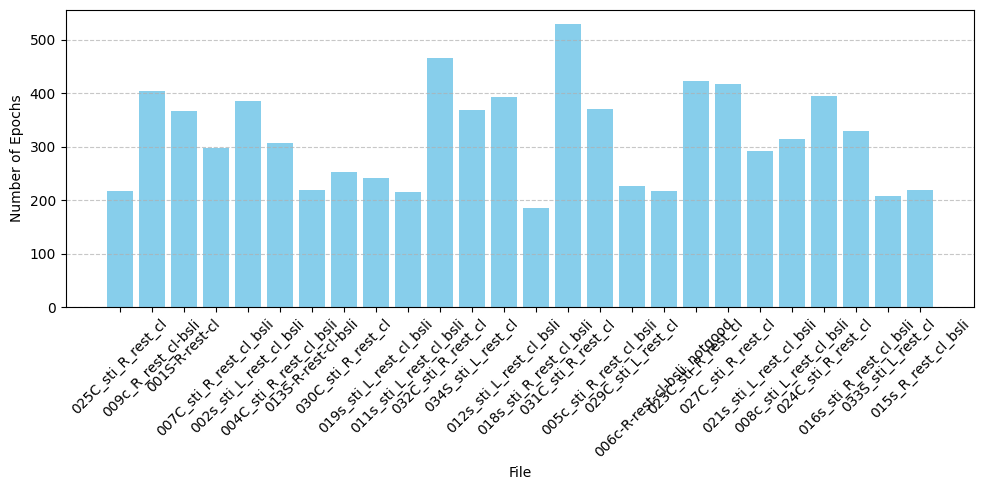

In [5]:
# Plot histogram of epochs per file
fl_names = list(fl_epo_con.keys())

# Remove file extensions from filenames (e.g., .txt, .csv)
fl_names_no_exten = [name.split('.')[0] for name in fl_names]

epoch_counts = list(fl_epo_con.values())

plt.figure(figsize=(10, 5))

# Plot bars with custom color
plt.bar(fl_names_no_exten, epoch_counts, color='skyblue')  # Change color here

plt.xlabel('File')
plt.ylabel('Number of Epochs')
# plt.title('Number of Epochs per File')

# Rotate file names if they overlap
plt.xticks(rotation=45)

# Add grid
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Grid only for the y-axis with dotted lines and some transparency

# Adjust layout to make room for rotated labels
plt.tight_layout()

plt.show()


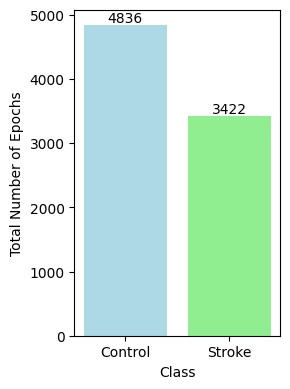

In [6]:

# Calculate the total number of epochs per class
class_counts = epochs_df['label'].value_counts().to_dict()

# Plot the total number of epochs by class
plt.figure(figsize=(3, 4))

# Map numeric labels to class names if needed
class_names = {0: 'Stroke', 1: 'Control'}
class_labels = [class_names.get(label, label) for label in class_counts.keys()]
epoch_counts = list(class_counts.values())

plt.bar(class_labels, epoch_counts, color=['lightblue', 'lightgreen'])
plt.xlabel('Class')
plt.ylabel('Total Number of Epochs')
# plt.title('Total Number of Epochs by Class')
plt.tight_layout()  # Adjust layout to fit labels

# Display the counts on top of bars
for i, count in enumerate(epoch_counts):
    plt.text(i, count + 50, str(count), ha='center')

plt.show()


In [7]:


# Extract epochs and labels from epochs_df
X = np.array(epochs_df['epoch'].tolist())  # Shape: (n_epochs, n_channels, n_times)
y = np.array(epochs_df['label'].tolist())  # Shape: (n_epochs,)

# Normalize the data
scaler = StandardScaler()
X = X.reshape(-1, X.shape[2])  # Flatten channels and time
X = scaler.fit_transform(X)
X = X.reshape(len(epochs_df), 12, 430)  # Reshape back to original dimensions

# Split data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Shape: (batch_size, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}, y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

# Custom DataLoader for handling excluded channels
class EEGDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# DataLoaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(EEGDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(EEGDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(EEGDataset(X_test, y_test), batch_size=batch_size, shuffle=False)




X_train shape: torch.Size([5284, 12, 430]), y_train shape: torch.Size([5284, 1])
X_val shape: torch.Size([1322, 12, 430]), y_val shape: torch.Size([1322, 1])
X_test shape: torch.Size([1652, 12, 430]), y_test shape: torch.Size([1652, 1])


In [8]:
# weighted for imbalance data
# Flatten y_train tensor to 1D array
y_train_np = y_train.numpy().flatten()

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_np), y=y_train_np)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Compute sample weights
cls_sample_con = np.bincount(y_train_np.astype(int))
class_weights = 1. / cls_sample_con
sample_weights = class_weights[y_train_np.astype(int)]

# Create the WeightedRandomSampler
weighted_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)


In [9]:
# Create DataLoader for batching

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, sampler=weighted_sampler)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [10]:
#eegnet test

import torch.nn.functional as F

class EEGNet(nn.Module):
    def __init__(self, num_channels, num_classes, F1=8, D=2, F2=16, kernLength=64, dropoutRate=0.5):
        super(EEGNet, self).__init__()
        
        # Block 1
        self.conv1 = nn.Conv2d(12, F1, (1, kernLength), padding=(0, kernLength // 2), bias=False)
        
        self.bn1 = nn.BatchNorm2d(F1)
        self.depthwiseConv = nn.Conv2d(F1, F1 * D, (1, 1), groups=F1, bias=False)
        self.bn2 = nn.BatchNorm2d(F1 * D)
        self.elu1 = nn.ELU()
        self.avgPool1 = nn.AvgPool2d((1, 4))
        self.dropout1 = nn.Dropout(dropoutRate)
        
        # Block 2
        self.separableConv = nn.Conv2d(F1 * D, F2, (1, 16), padding=(0, 8), groups=F1 * D, bias=False)
        self.bn3 = nn.BatchNorm2d(F2)
        self.elu2 = nn.ELU()
        self.avgPool2 = nn.AvgPool2d((1, 8))
        self.dropout2 = nn.Dropout(dropoutRate)
        
        # Fully Connected Layer
        self.flatten = nn.Flatten()
        # self.fc1 = nn.Linear(self._calculate_fc_input_size(num_channels), num_classes)

        self.fc1 = nn.Linear(self._calculate_fc_input_size(num_channels), num_classes)
    
    def _calculate_fc_input_size(self, num_channels):
        # Dummy input to calculate the size of the fully connected layer

        #since we want a shape of 1, 12,12, 430, switch numchannels with 1
        # dummy_input = torch.zeros((1, 12, 2, 430)) 
        dummy_input = torch.zeros((1, num_channels, 1, 430)) 
        x = self.forward_conv(dummy_input)

        print("Flattened shape for FC layer:", x.shape)
        # return x.view(x.size(0), -1).size(1)
        return x.numel() // x.shape[0]
    
    def forward_conv(self, x):
        # Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.depthwiseConv(x)
        x = self.bn2(x)
        x = self.elu1(x)
        x = self.avgPool1(x)
        x = self.dropout1(x)
        
        # Block 2
        x = self.separableConv(x)
        x = self.bn3(x)
        x = self.elu2(x)
        x = self.avgPool2(x)
        x = self.dropout2(x)
        
        return x
    
    def forward(self, x):
        x = self.forward_conv(x)
        x = self.flatten(x)
        print("Shape before FC layer:", x.shape)
        x = self.fc1(x)
        return x




# Parameters
num_channels = 12
num_classes = 1  # Binary classification

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EEGNet(num_channels=num_channels, num_classes=num_classes).to(device)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # For binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',           # We want to minimize the validation loss
    patience=3,           # If validation loss doesn't improve in 5 epochs, reduce LR
    factor=0.2,           # Reduce LR to 50% of the current value
    threshold=1e-4,       # Only reduce LR if the change in validation loss is smaller than this threshold
    cooldown=2,           # After reducing LR, wait for 2 epochs before making further adjustments
    min_lr=1e-5           # Optional: Set a minimum learning rate to prevent it from decaying too much
)

Flattened shape for FC layer: torch.Size([1, 16, 1, 13])


In [11]:
# # Define lists
# train_loss = []
# val_loss = []

# train_acc = []
# val_acc = []

# train_prec = []
# val_prec = []

# train_recalls = []
# val_recalls = []

# train_f1s = []
# val_f1s = []

# num_epochs = 50
# patience = 10  # Number of epochs to wait for improvement
# best_val_loss = np.inf
# epochs_wo_improve = 0

# for epoch in range(num_epochs):
#     model.train()
#     total_train_loss = 0
#     all_train_labels = []
#     all_train_predict = []

#     for data, labels in train_loader:

#         print("Input shape:", data.shape) 

#         # data = data.unsqueeze(1)
#         # data = data.permute(0, 2, 1)
#         data = data.view(data.shape[0], 12, 1, 430)

#         data, labels = data.to(device), labels.to(device)
#         outputs = model(data)
#         loss = criterion(outputs, labels)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_train_loss += loss.item()

#         # Convert outputs to predictions
#         predicted = (torch.sigmoid(outputs) > 0.5).float()
#         all_train_labels.extend(labels.cpu().numpy())
#         all_train_predict.extend(predicted.cpu().numpy())

#     # Convert lists to numpy arrays
#     all_train_labels = np.array(all_train_labels)
#     all_train_predict = np.array(all_train_predict)

#     # Calculate metrics
#     # train_acc = accuracy_score(all_train_labels, all_train_predict)
#     # train_prec = precision_score(all_train_labels, all_train_predict, average='binary')
#     # train_recall = recall_score(all_train_labels, all_train_predict, average='binary')
#     # train_f1 = f1_score(all_train_labels, all_train_predict, average='binary')

#     # train_loss.append(total_train_loss / len(train_loader))
#     # train_acc.append(train_acc)
#     # train_prec.append(train_prec)
#     # train_recalls.append(train_recall)
#     # train_f1s.append(train_f1)

#     train_acc_value = accuracy_score(all_train_labels, all_train_predict)
#     train_prec_value = precision_score(all_train_labels, all_train_predict, average='binary')
#     train_recall_value = recall_score(all_train_labels, all_train_predict, average='binary')
#     train_f1_value = f1_score(all_train_labels, all_train_predict, average='binary')

#     train_loss.append(total_train_loss / len(train_loader))
#     train_acc.append(train_acc_value)  # Append float to list
#     train_prec.append(train_prec_value)
#     train_recalls.append(train_recall_value)
#     train_f1s.append(train_f1_value)

#     # Validation
#     model.eval()
#     total_val_loss = 0
#     all_val_labels = []
#     all_val_predict = []

#     with torch.no_grad():
#         for data, labels in val_loader:
#             print("Validation Input shape:", data.shape)
#             data, labels = data.to(device), labels.to(device)
#             outputs = model(data)
#             loss = criterion(outputs, labels)

#             total_val_loss += loss.item()

#             # Convert outputs to predictions
#             predicted = (torch.sigmoid(outputs) > 0.5).float()
#             all_val_labels.extend(labels.cpu().numpy())
#             all_val_predict.extend(predicted.cpu().numpy())

#     scheduler.step(total_val_loss)

#     # Convert lists to numpy arrays
#     all_val_labels = np.array(all_val_labels)
#     all_val_predict = np.array( all_val_predict)

#     # Calculate metrics
#     val_acc = accuracy_score(all_val_labels,  all_val_predict)
#     val_prec = precision_score(all_val_labels,  all_val_predict, average='binary')
#     val_recall = recall_score(all_val_labels,  all_val_predict, average='binary')
#     val_f1 = f1_score(all_val_labels,  all_val_predict, average='binary')

#     val_loss.append(total_val_loss / len(val_loader))
#     val_acc.append(val_acc)
#     val_prec.append(val_prec)
#     val_recalls.append(val_recall)
#     val_f1s.append(val_f1)

#     print(f'Epoch [{epoch+1}/{num_epochs}] - '
#           f'Train Loss: {train_loss[-1]:.4f}, Train Accuracy: {train_acc:.4f}, '
#           f'Train Precision: {train_prec:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f} - '
#           f'Val Loss: {val_loss[-1]:.4f}, Val Accuracy: {val_acc:.4f}, '
#           f'Val Precision: {val_prec:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}')



# import torch
# import torch.nn as nn
# import numpy as np
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define lists
train_loss = []
val_loss = []

train_acc_list = []
val_acc_list = []

train_prec_list = []
val_prec_list = []

train_recalls_list = []
val_recalls_list = []

train_f1s_list = []
val_f1s_list = []

num_epochs = 50
patience = 10  # Number of epochs to wait for improvement
best_val_loss = np.inf
epochs_wo_improve = 0

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    all_train_labels = []
    all_train_predict = []

    for data, labels in train_loader:
        print("Input shape (train) before reshape:", data.shape) 
        # Reshape to (batch_size, 12, 1, 430)
        data = data.view(data.shape[0], 12, 1, 430)

        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        # Convert outputs to predictions
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        all_train_labels.extend(labels.cpu().numpy())
        all_train_predict.extend(predicted.cpu().numpy())

    # Convert lists to numpy arrays
    all_train_labels = np.array(all_train_labels)
    all_train_predict = np.array(all_train_predict)

    # Calculate metrics (train)
    train_acc_value = accuracy_score(all_train_labels, all_train_predict)
    train_prec_value = precision_score(all_train_labels, all_train_predict, average='binary')
    train_recall_value = recall_score(all_train_labels, all_train_predict, average='binary')
    train_f1_value = f1_score(all_train_labels, all_train_predict, average='binary')

    train_loss_value = total_train_loss / len(train_loader)
    train_loss.append(train_loss_value)
    train_acc_list.append(train_acc_value)
    train_prec_list.append(train_prec_value)
    train_recalls_list.append(train_recall_value)
    train_f1s_list.append(train_f1_value)

    # Validation
    model.eval()
    total_val_loss = 0
    all_val_labels = []
    all_val_predict = []

    with torch.no_grad():
        for data, labels in val_loader:
            print("Input shape (val) before reshape:", data.shape)
            # IMPORTANT: reshape the validation data as well
            data = data.view(data.shape[0], 12, 1, 430)

            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()

            # Convert outputs to predictions
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            all_val_labels.extend(labels.cpu().numpy())
            all_val_predict.extend(predicted.cpu().numpy())

    scheduler.step(total_val_loss)

    # Convert lists to numpy arrays (val)
    all_val_labels = np.array(all_val_labels)
    all_val_predict = np.array(all_val_predict)

    # Calculate metrics (val)
    val_acc_value = accuracy_score(all_val_labels, all_val_predict)
    val_prec_value = precision_score(all_val_labels, all_val_predict, average='binary')
    val_recall_value = recall_score(all_val_labels, all_val_predict, average='binary')
    val_f1_value = f1_score(all_val_labels, all_val_predict, average='binary')

    val_loss_value = total_val_loss / len(val_loader)
    val_loss.append(val_loss_value)
    val_acc_list.append(val_acc_value)
    val_prec_list.append(val_prec_value)
    val_recalls_list.append(val_recall_value)
    val_f1s_list.append(val_f1_value)

    print(f'Epoch [{epoch+1}/{num_epochs}] '
          f'- Train Loss: {train_loss_value:.4f}, Train Accuracy: {train_acc_value:.4f}, '
          f'Train Precision: {train_prec_value:.4f}, Train Recall: {train_recall_value:.4f}, Train F1: {train_f1_value:.4f} '
          f'- Val Loss: {val_loss_value:.4f}, Val Accuracy: {val_acc_value:.4f}, '
          f'Val Precision: {val_prec_value:.4f}, Val Recall: {val_recall_value:.4f}, Val F1: {val_f1_value:.4f}'
         )




Input shape (train) before reshape: torch.Size([64, 12, 430])
Shape before FC layer: torch.Size([64, 208])
Input shape (train) before reshape: torch.Size([64, 12, 430])
Shape before FC layer: torch.Size([64, 208])
Input shape (train) before reshape: torch.Size([64, 12, 430])
Shape before FC layer: torch.Size([64, 208])
Input shape (train) before reshape: torch.Size([64, 12, 430])
Shape before FC layer: torch.Size([64, 208])
Input shape (train) before reshape: torch.Size([64, 12, 430])
Shape before FC layer: torch.Size([64, 208])
Input shape (train) before reshape: torch.Size([64, 12, 430])
Shape before FC layer: torch.Size([64, 208])
Input shape (train) before reshape: torch.Size([64, 12, 430])
Shape before FC layer: torch.Size([64, 208])
Input shape (train) before reshape: torch.Size([64, 12, 430])
Shape before FC layer: torch.Size([64, 208])
Input shape (train) before reshape: torch.Size([64, 12, 430])
Shape before FC layer: torch.Size([64, 208])
Input shape (train) before reshape: t

In [13]:
# # Lists to store metrics for plotting
# test_loss = []
# test_acc = []
# test_prec = []
# test_recalls = []
# test_f1s = []

# # Lists to store samples
# cor_stroke_samples = []
# incor_stroke_samples = []
# cor_control_samples = []
# incor_control_samples = []


# # Evaluation on test dataset
# model.eval()
# total_test_loss = 0
# cor_test = 0
# total_test = 0
# all_test_labels = []
# all_test_pred = []

# with torch.no_grad():
#     for data, labels in test_loader:
#         data, labels = data.to(device), labels.to(device)
#         outputs = model(data)
#         loss = criterion(outputs, labels)

#         total_test_loss += loss.item()
#         total_test += labels.size(0)

#         # Convert outputs to predictions
#         predicted = (torch.sigmoid(outputs) > 0.5).float()
#         cor_test += (predicted == labels).sum().item()


#         all_test_labels.extend(labels.cpu().numpy())
#         all_test_pred.extend(predicted.cpu().numpy())

#         # Check for correct and incorrect classifications
#         for i in range(len(labels)):
#             if labels[i] == 0:  # Stroke
#                 if predicted[i] == labels[i]:
#                     cor_stroke_samples.append(data[i].cpu())  # Store correctly classified stroke sample
#                 else:
#                     incor_stroke_samples.append(data[i].cpu())  # Store incorrectly classified stroke sample
#             elif labels[i] == 1:  # Control
#                 if predicted[i] == labels[i]:
#                     cor_control_samples.append(data[i].cpu())  # Store correctly classified control sample
#                 else:
#                     incor_control_samples.append(data[i].cpu())  # Store incorrectly classified control sample


# # Calculate test loss and accuracy
# test_loss = total_test_loss / len(test_loader)
# test_acc = cor_test / total_test

# # Convert lists to numpy arrays
# all_test_labels = np.array(all_test_labels)
# all_test_pred = np.array(all_test_pred)

# # Calculate precision, recall, and F1 score for multiclass classification (macro average)
# test_precision = precision_score(all_test_labels, all_test_pred, average='macro')
# test_recall = recall_score(all_test_labels, all_test_pred, average='macro')
# test_f1 = f1_score(all_test_labels, all_test_pred, average='macro')

# # Store test metrics
# test_loss.append(test_loss)
# test_acc.append(test_acc)
# test_prec.append(test_precision)
# test_recalls.append(test_recall)
# test_f1s.append(test_f1)

# # Output results
# print(f'Test Loss: {test_loss:.4f}')
# print(f'Test Accuracy: {test_acc:.4f}')
# print(f'Test Precision (Macro): {test_precision:.4f}')
# print(f'Test Recall (Macro): {test_recall:.4f}')
# print(f'Test F1 Score (Macro): {test_f1:.4f}')


# # Optionally, print the number of correct and incorrect samples
# print(f'Correctly classified Stroke samples: {len(cor_stroke_samples)}')
# print(f'Incorrectly classified Stroke samples: {len(incor_stroke_samples)}')
# print(f'Correctly classified Control samples: {len(cor_control_samples)}')
# print(f'Incorrectly classified Control samples: {len(incor_control_samples)}')




# Lists to store metrics for plotting
test_loss_list = []
test_acc_list = []
test_prec_list = []
test_recalls_list = []
test_f1s_list = []

# Lists to store samples
cor_stroke_samples = []
incor_stroke_samples = []
cor_control_samples = []
incor_control_samples = []

# Evaluation on test dataset
model.eval()
total_test_loss = 0
cor_test = 0
total_test = 0
all_test_labels = []
all_test_pred = []

with torch.no_grad():
    for data, labels in test_loader:
        print("Test Input shape before reshape:", data.shape)
        # Reshape to match training shape: (batch_size, 12, 1, 430)
        data = data.view(data.shape[0], 12, 1, 430)
        
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        loss = criterion(outputs, labels)

        total_test_loss += loss.item()
        total_test += labels.size(0)

        # Convert outputs to predictions
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        cor_test += (predicted == labels).sum().item()

        all_test_labels.extend(labels.cpu().numpy())
        all_test_pred.extend(predicted.cpu().numpy())

        # Check for correct and incorrect classifications
        for i in range(len(labels)):
            if labels[i] == 0:  # Stroke
                if predicted[i] == labels[i]:
                    cor_stroke_samples.append(data[i].cpu())  
                else:
                    incor_stroke_samples.append(data[i].cpu()) 
            elif labels[i] == 1:  # Control
                if predicted[i] == labels[i]:
                    cor_control_samples.append(data[i].cpu()) 
                else:
                    incor_control_samples.append(data[i].cpu())

# Calculate aggregate test metrics
test_loss_value = total_test_loss / len(test_loader)
test_acc_value = cor_test / total_test

# Convert lists to numpy arrays
all_test_labels = np.array(all_test_labels)
all_test_pred = np.array(all_test_pred)

# Calculate precision, recall, and F1 score
# (If truly binary classification, you can change `average='macro'` to `average='binary'`)
test_precision_value = precision_score(all_test_labels, all_test_pred, average='macro')
test_recall_value = recall_score(all_test_labels, all_test_pred, average='macro')
test_f1_value = f1_score(all_test_labels, all_test_pred, average='macro')

# Store in the lists (in case you want to plot or track them later)
test_loss_list.append(test_loss_value)
test_acc_list.append(test_acc_value)
test_prec_list.append(test_precision_value)
test_recalls_list.append(test_recall_value)
test_f1s_list.append(test_f1_value)

# Print results
print(f'Test Loss: {test_loss_value:.4f}')
print(f'Test Accuracy: {test_acc_value:.4f}')
print(f'Test Precision (Macro): {test_precision_value:.4f}')
print(f'Test Recall (Macro): {test_recall_value:.4f}')
print(f'Test F1 Score (Macro): {test_f1_value:.4f}')

# Optionally, print the number of correct and incorrect samples
# print(f'Correctly classified Stroke samples: {len(cor_stroke_samples)}')
# print(f'Incorrectly classified Stroke samples: {len(incor_stroke_samples)}')
# print(f'Correctly classified Control samples: {len(cor_control_samples)}')
# print(f'Incorrectly classified Control samples: {len(incor_control_samples)}')


Test Input shape before reshape: torch.Size([64, 12, 430])
Shape before FC layer: torch.Size([64, 208])
Test Input shape before reshape: torch.Size([64, 12, 430])
Shape before FC layer: torch.Size([64, 208])
Test Input shape before reshape: torch.Size([64, 12, 430])
Shape before FC layer: torch.Size([64, 208])
Test Input shape before reshape: torch.Size([64, 12, 430])
Shape before FC layer: torch.Size([64, 208])
Test Input shape before reshape: torch.Size([64, 12, 430])
Shape before FC layer: torch.Size([64, 208])
Test Input shape before reshape: torch.Size([64, 12, 430])
Shape before FC layer: torch.Size([64, 208])
Test Input shape before reshape: torch.Size([64, 12, 430])
Shape before FC layer: torch.Size([64, 208])
Test Input shape before reshape: torch.Size([64, 12, 430])
Shape before FC layer: torch.Size([64, 208])
Test Input shape before reshape: torch.Size([64, 12, 430])
Shape before FC layer: torch.Size([64, 208])
Test Input shape before reshape: torch.Size([64, 12, 430])
Shape

NameError: name 'train_acc' is not defined

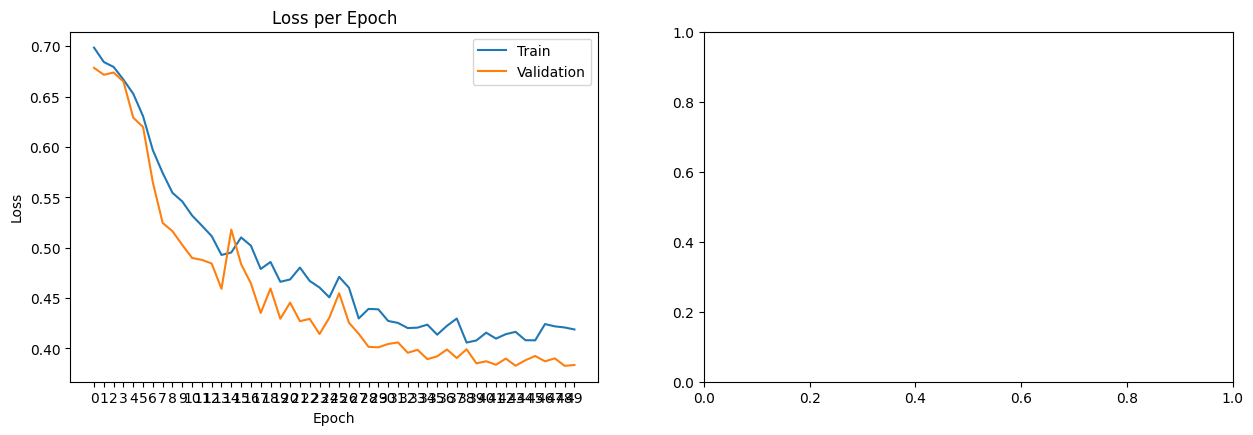

In [14]:

# num_epochs_run = len(train_loss)  

# plt.figure(figsize=(15, 10))

# # Loss plot
# plt.subplot(2, 2, 1)
# plt.plot(range(num_epochs_run), train_loss, label='Train')
# plt.plot(range(num_epochs_run), val_loss, label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Loss per Epoch')
# plt.legend()
# plt.xticks(range(num_epochs_run))  # Set x-axis to show integers

# # Accuracy plot
# plt.subplot(2, 2, 2)
# plt.plot(range(num_epochs_run), train_acc, label='Train')
# plt.plot(range(num_epochs_run), val_acc, label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Accuracy per Epoch')
# plt.legend()
# plt.xticks(range(num_epochs_run))  # Set x-axis to show integers

# # Precision plot
# plt.subplot(2, 2, 3)
# plt.plot(range(num_epochs_run), train_prec, label='Train')
# plt.plot(range(num_epochs_run), val_prec, label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('Precision')
# plt.title('Precision per Epoch')
# plt.legend()
# plt.xticks(range(num_epochs_run))  # Set x-axis to show integers

# # Recall plot
# plt.subplot(2, 2, 4)
# plt.plot(range(num_epochs_run), train_recalls, label='Train')
# plt.plot(range(num_epochs_run), val_recalls, label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('Recall')
# plt.title('Recall per Epoch')
# plt.legend()
# plt.xticks(range(num_epochs_run))  # Set x-axis to show integers

# plt.tight_layout()
# plt.show()




# Suppose after training you have these lists filled:
# train_loss, val_loss = [...]
# train_acc,  val_acc  = [...]
# train_prec, val_prec = [...]
# train_recalls, val_recalls = [...]

num_epochs_run = len(train_loss)  # Make sure all your lists have the same length!

plt.figure(figsize=(15, 10))

# 1) Loss plot
plt.subplot(2, 2, 1)
plt.plot(range(num_epochs_run), train_loss, label='Train')
plt.plot(range(num_epochs_run), val_loss, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.xticks(range(num_epochs_run))

# 2) Accuracy plot
plt.subplot(2, 2, 2)
plt.plot(range(num_epochs_run), train_acc, label='Train')
plt.plot(range(num_epochs_run), val_acc, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.xticks(range(num_epochs_run))

# 3) Precision plot
plt.subplot(2, 2, 3)
plt.plot(range(num_epochs_run), train_prec, label='Train')
plt.plot(range(num_epochs_run), val_prec, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision per Epoch')
plt.legend()
plt.xticks(range(num_epochs_run))

# 4) Recall plot
plt.subplot(2, 2, 4)
plt.plot(range(num_epochs_run), train_recalls, label='Train')
plt.plot(range(num_epochs_run), val_recalls, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall per Epoch')
plt.legend()
plt.xticks(range(num_epochs_run))

plt.tight_layout()
plt.show()


